In [29]:
# !pip install grad-cam

In [30]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image

In [31]:

import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os
import warnings

from pathlib import Path

from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict

# from datasets import build_dataset
from datasetsV2 import build_dataset
from engine import train_one_epoch, evaluate
from samplers import RASampler
import models
import utils
import sys
import cv2
from datasetsV2 import get_transform_to_eval, get_transform_to_eval_NO_SRM
from torchvision.transforms import ToPILImage

from PIL import Image
import matplotlib.pyplot as plt

In [32]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [33]:
model = create_model(
    'crossvit_18_dagger_224',
    pretrained=True,
    num_classes=1
)

ViT with 1 classes.


In [34]:
checkpoint = torch.load('old_logs/14_no_srm/model_best.pth', map_location='cpu')
utils.load_checkpoint(model, checkpoint['model'])

INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmpd5_gocfh ...


In [35]:
model.eval()

VisionTransformer(
  (patch_embed): ModuleList(
    (0): PatchEmbed(
      (proj): Sequential(
        (0): Conv2d(3, 56, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (1): ReLU(inplace=True)
        (2): Conv2d(56, 112, kernel_size=(3, 3), stride=(3, 3))
        (3): ReLU(inplace=True)
        (4): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PatchEmbed(
      (proj): Sequential(
        (0): Conv2d(3, 112, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (1): ReLU(inplace=True)
        (2): Conv2d(112, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): Conv2d(224, 448, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
  )
  (pos_embed): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x401x224]
      (1): Parameter containing: [torch.float32 of size 1x197x448]
  )
  (cls_token): ParameterList(
      (0): Parameter containing: [to

In [36]:
def preprocess_image_transform(image_path, transform):
    image = Image.open(image_path).convert('RGB').resize((224, 224))
    image = np.array(image)
    augmented = transform(image=image)
    return augmented['image'].unsqueeze(0), image 

In [37]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [38]:
transform = get_transform_to_eval_NO_SRM(224)

In [39]:
for name, module in model.named_modules():
    # print(name)
    pass

In [40]:
model.to(device)
target_layers = [model.blocks[2].blocks[1][5].attn]
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

In [41]:
# images_to_paper = {
#     'DFDC':{
#         'real': '/home/eferreira/master/storage/dfdc/dfdc/test/reorganized/faces/aarpyivfys/0_0.png',
#         'fake': 
#     }
# }

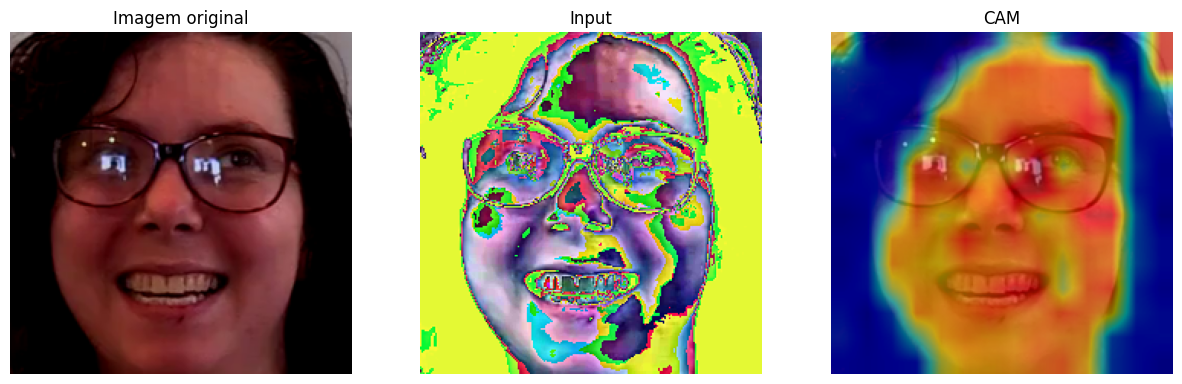

0.05508245900273323
REAL


In [42]:
# image_name = '4040_1292_0'
# image_file = f"/home/eferreira/master/custom_vit/datasets/dfdc/val/faces/{image_name}.png"
image_file = '/home/eferreira/master/storage/dfdc/dfdc/test/reorganized/faces/aarpyivfys/0_0.png'
input_tensor, original = preprocess_image_transform(image_file, transform)

original = np.float32(original) / 255

targets = None
cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor, targets=targets, eigen_smooth=False, aug_smooth=False)

grayscale_cam = grayscale_cam[0, :]

cam_image = show_cam_on_image(original, grayscale_cam)

input_image = ToPILImage()(input_tensor.squeeze(0).cpu())

plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.title('Imagem original')
plt.imshow(original)
plt.axis('off')


plt.subplot(1, 3, 2)
plt.title('Input')
plt.imshow(input_image)
plt.axis('off')


plt.subplot(1, 3, 3)
plt.title('CAM')
plt.imshow(cam_image)
plt.axis('off')

plt.show()


# filename = image_file.split("/")[-1].split('.')[0]
# cv2.imwrite(f'cam/{filename}_cam.jpg', cam_image)
pred = torch.sigmoid(cam.outputs)
print(pred.item())
result = "FAKE" if pred.item() > 0.5 else "REAL"
print(result)

In [43]:
# model.to(device)
# target_layers = [model.blocks[2].blocks[1][5].attn]
# cam = GradCAM(model=model,
#             target_layers=target_layers,
#             reshape_transform=reshape_transform)
# input_tensor, original = preprocess_image_transform(image_file, transform)
# original = np.float32(original) / 255
# targets = None
# cam.batch_size = 32
# grayscale_cam = cam(input_tensor=input_tensor,
#                         targets=targets,
#                         eigen_smooth=False,
#                         aug_smooth=False)

# # Here grayscale_cam has only one image in the batch
# grayscale_cam = grayscale_cam[0, :]

# cam_image = show_cam_on_image(original, grayscale_cam)
# filename = image_file.split("/")[-1].split('.')[0]
# cv2.imwrite(f'cam/{filename}_cam.jpg', cam_image)
# pred = torch.sigmoid(cam.outputs)
# result = "FAKE" if pred.item() > 0.5 else "REAL"
# print(result)